In [1]:
%env THEANO_FLAGS=mode=FAST_RUN,device=gpu0
import sys
sys.path.insert(0,'../')

import network
reload(network)

net = network.Net()
net.change_lr(0.001)

env: THEANO_FLAGS=mode=FAST_RUN,device=gpu0


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
import data_loader
reload(data_loader)

from data_loader import DataLoader

classes = [wnid.strip() for wnid in open('../synsets.txt').readlines()]
dataset = DataLoader( '../../ilsvrc2012','/home/nine/workspace/caffe/data/ilsvrc12/train.txt','/home/nine/workspace/caffe/data/ilsvrc12/val.txt')

In [3]:
from PIL import Image
import preprocessor
reload(preprocessor)
from preprocessor import Fetcher
import tree_distance
reload(tree_distance)
from tree_distance import Distance
import cPickle as pickle

mean = pickle.load(open('mean.pkl'))
fetcher = Fetcher('center',mean)
distance = Distance('../wordnet.is_a.txt','../synsets.txt')

In [4]:
#net.load_model('trained.pkl')
#pickle.dump(pickle.load(open('../../models/vgg_cnn_s.pkl'))['values'],open('trained.pkl','wb'))
net.load_model('trained.pkl')

In [7]:
from multiprocessing import Pool, Process, Queue, Value
import sys, datetime

def fetch(q,max_buf,flag,fetcher,distance) :
    while(flag.value != 0) :
        if( q.qsize() < max_buf ) :
            fetched1 = dataset.fetch_train(64)
            fetched2 = dataset.fetch_train(64)

            ims1 = fetcher.fetch(fetched1)
            ims2 = fetcher.fetch(fetched2)
            dist = distance.dist(fetched1,fetched2)
            q.put((ims1,ims2,dist))
            
#             import datetime
#             print 'Enqueued', datetime.datetime.now()
#             sys.stdout.flush()

            
q = Queue()
flag = Value('d', 1) 
p = Process(target=fetch,args=(q,10,flag,fetcher,distance))

p.start()

import logging
logging.basicConfig(filename='train.log',level=logging.DEBUG)

net.change_lr(0.001)
for i in range(100000):
    ims1,ims2,dist = q.get()
    loss = net.train(ims1,ims2,dist)
    
    import datetime
#     print 'Trained', datetime.datetime.now()
#     sys.stdout.flush()
    if i % 10 == 0 :
        log = "{},{},{}".format(datetime.datetime.now(), i, loss)
        print log
        sys.stdout.flush()
        
        logging.info(log)

flag.value = 0
p.join()

2015-09-28 20:07:26.427374,0,[array(6.8139872550964355, dtype=float32)]
2015-09-28 20:07:45.783787,10,[array(8.873834609985352, dtype=float32)]
2015-09-28 20:08:08.358569,20,[array(6.754319190979004, dtype=float32)]
2015-09-28 20:08:30.096599,30,[array(6.658018112182617, dtype=float32)]
2015-09-28 20:08:55.302891,40,[array(6.112260818481445, dtype=float32)]
2015-09-28 20:09:18.329066,50,[array(5.181430816650391, dtype=float32)]
2015-09-28 20:09:48.976105,60,[array(5.2659077644348145, dtype=float32)]
2015-09-28 20:10:19.840585,70,[array(5.206087589263916, dtype=float32)]
2015-09-28 20:10:50.654766,80,[array(5.224477767944336, dtype=float32)]
2015-09-28 20:11:21.404657,90,[array(5.1550188064575195, dtype=float32)]
2015-09-28 20:11:49.624135,100,[array(5.020467281341553, dtype=float32)]
2015-09-28 20:12:18.836457,110,[array(5.525124549865723, dtype=float32)]
2015-09-28 20:12:49.393021,120,[array(5.298912048339844, dtype=float32)]
2015-09-28 20:13:21.274518,130,[array(5.353689193725586, dt

KeyboardInterrupt: 

In [8]:
net.save_model('trained.pkl')

n03125729 n01735189 [[ 16.]] [ 0.4691757]


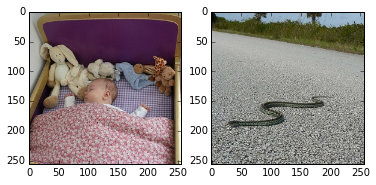

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fetch_1 = dataset.fetch_val(1)
fetch_2 = dataset.fetch_val(1)

plt.subplot(121)
plt.imshow(Image.open(fetch_1[0][1]))
plt.subplot(122)
plt.imshow(Image.open(fetch_2[0][1]))

dist,_,_ = net.test(fetcher.fetch(fetch_1),fetcher.fetch(fetch_2))
print classes[fetch_1[0][0]], classes[fetch_2[0][0]], distance.dist(fetch_1,fetch_2), dist